In [259]:
import numpy as np
from scipy.special import logsumexp
import itertools
np.seterr(divide='ignore')


def assert_dist_non_negative(log_p):
    assert np.all(log_p <= 0)


def assert_dist_sums_to_1(log_p, axis, check_idx=None):
    if check_idx is None: assert np.all(np.isclose(np.exp(logsumexp(log_p, axis=axis)), 1))
    else: assert np.all(np.isclose(np.exp(logsumexp(log_p, axis=axis)[check_idx]), 1))


def _log_forward(data_obs, log_p, log_t_mat, log_e_mat, val_X, T):
    """
    F[1, k] = p(X_1 = k, o_1) = p(o_1 | X_1 = k) * p(X_1 = k) = e[k -> o_1] * p[k]
    F[t, k] = p(X_t = k, o_{1:t}) = e[k -> o_t] * sum_l[ F[t-1, l] * tau[l -> k] ]
    shape = N x T x |Val(X)|
    """
    N = data_obs.shape[0]
    log_F = np.zeros((N, T, len(val_X))) - np.inf
    log_F[:, 0] = log_p + log_e_mat[:, data_obs[:, 0]].T
    for t in range(1, T):
        temp = log_F[:, t - 1, None] + log_t_mat.T[None, :]
        log_F[:, t] = logsumexp(temp + log_e_mat[:, data_obs[:, t]].T[:, :, None], axis=2)

    # tests
    assert_dist_non_negative(log_F)
    return log_F


class HMM:
    def __init__(self, T, val_X, val_O, prior, transition_mat, emission_mat):
        self.T = T
        self.val_X = val_X
        self.val_O = val_O
        self.log_prior = np.log(prior)
        self.log_transition_mat = np.log(transition_mat)
        self.log_emission_mat = np.log(emission_mat)

    def get_CPDs(self):
        return {'prior': np.exp(self.log_prior),
                'transition_mat': np.exp(self.log_transition_mat),
                'emission_mat': np.exp(self.log_emission_mat)}

    def print_CPDs(self):
        cpds = self.get_CPDs()
        k = 'prior'
        print(k)
        print(np.array([f'prior({x})={cpds[k][x]:.3f}' for x in self.val_X]))
        k = 'transition_mat'
        print(k)
        print(np.array([[f'tau({xt}->{xtp1})={cpds[k][xtp1][xt]:.3f}' for xt in self.val_X] for xtp1 in self.val_X]))
        k = 'emission_mat'
        print(k)
        print(np.array([[f'e({xt}->{ot})={cpds[k][xt][ot]:.3f}' for ot in self.val_O] for xt in self.val_X]))

    ########################################
    ##########      Sampling      ##########
    ########################################
    def sample(self, N=1):
        """
        TODO sample N samples from the HMM.
        Assumes that the HMM CPDs are defined.
        :param N: optional, default=1. Number of samples.
        :return: (hidden, obs) for N samples from the HMM. shape of hidden & obs = (N,hmm.T)
        """
        cpds = self.get_CPDs()

        hidden_samples = np.zeros((N, self.T), dtype=int)
        obs_samples = np.zeros((N, self.T), dtype=int)
        
        for n in range(N): 
            hidden_samples[n, 0] = np.random.choice(self.val_X, p=cpds['prior'])
            obs_samples[n, 0] = np.random.choice(self.val_O, p=cpds['emission_mat'][hidden_samples[n, 0]])

            for t in range(1, self.T):
                hidden_samples[n, t] = np.random.choice(self.val_X, p=cpds['transition_mat'][hidden_samples[n, t-1]])
                obs_samples[n, t] = np.random.choice(self.val_O, p=cpds['emission_mat'][hidden_samples[n, t]])

        return (hidden_samples, obs_samples)

    
        

    ########################################
    ##########     Calc Prob.     ##########
    ########################################
    def log_joint(self, hidden, obs):
        """
        TODO calculate the log joint probability of the hidden, observations sequences for each sample p(x1:T[t],o1:T[i]).
        :param hidden - N hidden sequences. shape = (N,T)
        :param obs - N observations. shape = (N,T)
        :return log-joint probability. shape = (N)       
        
        c3 = log(p1 * p2) = log(p1) + log(p2) = c1 + c2
        """
        N, T = hidden.shape
        log_p = self.log_prior[hidden[:, 0]] + self.log_emission_mat[hidden[:, 0], obs[:, 0]]
        
        for t in range(1, T):
            log_p += self.log_transition_mat[hidden[:, t-1], hidden[:, t]] + self.log_emission_mat[hidden[:, t], obs[:, t]]

        return log_p

        

    def naive_log_likelihood(self, obs):
        """
        Calculate the log likelihood of the observations for each sample p(o1:T[i]) in a naive way (going over all
        possibilities). This will take many resources for T>5.
        :param obs - N observations. shape = (N,T)
        :return log-likelihood. shape = (N)
        """
        assert self.T < 6
        X = set(itertools.permutations(np.array([[x] * self.T for x in self.val_X]).flatten(), self.T))
        p = []
        for x in X:
            p.append(self.log_joint(np.broadcast_to(x, obs.shape), obs))
        return logsumexp(p, axis=0)

    def log_likelihood(self, obs):
        """
        TODO calculate the log likelihood of the observations for each sample p(o1:T[i]).
             Use the supplied forward-algorithm.
        :param obs - N observations. shape = (N,T)
        :return log-likelihood. shape = (N)
        
        log(p(o_[1:T]) = log (    sum_{k in Val(X)} p(o_1, ... , o_T, k) )     )
                       = log( sum_{k in Val(X)} exp ( log_p(o_1, ... , o_T, k) ) )
                       = log( sum_{k in Val(X)} exp ( F[T,k] )    )
        """
        log_forward = _log_forward(obs, self.log_prior, self.log_transition_mat, self.log_emission_mat, self.val_X, self.T)
        return logsumexp(log_forward[:, self.T-1, :], axis=1)
        
        

    def log_prior_Xt(self):
        """
        TODO calculate the point-wise prior p(X_t=x)
        :return point-wise prior. shape = (T, |val(X)|)
        P'[t, k] = p(X_t = k) = sum_{l in Val(x)} p(X_t = k | X_{t-1}=l) * p(X_{t-1} = l) 
                             = sum_{l in Val(x)} P(X_t = k | X_{t-1}=l) * P'[t-1, l] 
                             = P(X_t = k | X_{t-1}=l_1) * P'[t-1, l_1] + ...  P(X_t = k | X_{t-1}=l_n) * P'[t-1, l_n]  
                             
        P[t, k] = logp(X_t = k) = logp( exp(   logp(X_t = k | X_{t-1}=l_1) + P[t, l_1])   ) + ... + exp(   logp(X_t = k | X_{t-1}=l_n) + P[t, l_n])   ) )
        """
        val_X_len = len(self.val_X)
        log_p_Xt = np.full((self.T, val_X_len), -np.inf)
        log_p_Xt[0] = self.log_prior
        for t in range(1, self.T):
            for val_X_index in range(val_X_len):
                log_p_Xt[t, val_X_index] = logsumexp( self.log_transition_mat[: , val_X_index] + log_p_Xt[t-1, :])
        
        # tests
        assert_dist_non_negative(log_p_Xt)   # p(Xt = k) >= 0
        assert_dist_sums_to_1(log_p_Xt, axis=-1)  # sum_k[ p(Xt = k) ] == 1
        return log_p_Xt

    def log_naive_posterior_Xt(self, obs):
        """
        TODO calculate the point-wise posterior p(X_t=x | ot=obs[i][t])
        :param obs - N observations. shape = (N,T)
        :return point-wise posterior. shape = (N, T, |val(X)|)
        
        log( p(X_t = x_t | O_t = o_t) ) = log(     p(X_t = x_t) * p(O_t = o_t | X_t = x_t)    /    sum_{x in Val(X)}  p(X_t = x) * p(O_t = o_t | X_t = x)  )
                                      = log_p(X_t = x) + log_p(O = o_t| X = x) - log(sum_{x in Val(X)}  p(X_t = x) * p(O = o_t | X = x)  )
                                      = log_p(X_t = x) + log_p(O = o_t| X = x) - log(sum_{x in Val(X)}  exp( log_p(X_t = x) + log_p(O = o_t | X = x)  )
        
        """
        N = len(obs)
        val_X_len = len(self.val_X)
        
        log_prior_Xt = self.log_prior_Xt()
        log_posterior_Xt_given_Ot = np.full( (N, self.T, val_X_len), -np.inf)
        
        for n in range(N):
            for t in range(self.T):
                log_p_Xt = log_prior_Xt[t]
                log_p_O_given_X = self.log_emission_mat[ : , obs[n, t]]
                log_posterior_Xt_given_Ot[n, t, :] = log_p_Xt + log_p_O_given_X - logsumexp(log_p_Xt + log_p_O_given_X)

        
        # tests
        assert_dist_non_negative(log_posterior_Xt_given_Ot)  # p(Xt = k | ot) >= 0
        assert_dist_sums_to_1(log_posterior_Xt_given_Ot, axis=-1)  # sum_k[ p(Xt = k | ot) ] == 1
        return log_posterior_Xt_given_Ot

    ########################################
    ##########     Prediction     ##########
    ########################################
    def naive_predict_by_naive_posterior(self, obs):
        """
        TODO predict a sequence of hidden states for each sample using the point-wise posterior:
            X_hat[i][t] = argmax_x[ p(X_t=x | ot=obs[i][t]) ]
        :param obs - N observations. shape = (N,T)
        :return X_hat - N hidden sequences. shape = (N,T)
        """
        pass


########################################
########################################
########################################
########################################
########################################
########################################
########################################
########################################



import os
# from HMM_proj1 import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


########################################
##########        Utils       ##########
########################################
def load_data(file_name, data_path='data/'):
    return pd.read_csv(data_path + file_name + '.csv', index_col=0).values


def get_hmm(num_hmm):
    # define HMMs
    val_X = np.arange(2)
    val_O = np.arange(2)
    if num_hmm == 1:
        hmm_params = {
            'prior': np.array([0.849, 0.151]),
            'transition_mat': np.array([[0.75, 0.25],  # p(X_{t+1}=x | X_t=0)
                                        [0.25, 0.75]]),   # p(X_{t+1}=x | X_t=1)
            'emission_mat': np.array([[0.83, 0.17], # p(O_t=o | X_t = 0)
                                      [0.17, 0.83]]) # p(O_t=o | X_t = 1)
        }
        T = 1000

    elif num_hmm == 2:
        hmm_params = {
            'prior': np.array([1, 0]),
            'transition_mat': np.array([[0.999, 0.001],
                                        [0.005, 0.995]]),
            'emission_mat': np.array([[0.99, 0.01],
                                      [0.01, 0.99]])
        }
        T = 1000
    elif num_hmm == 3:
        hmm_params = {
            'prior': np.array([1, 0]),
            'transition_mat': np.array([[0.999, 0.001],
                                        [0, 1]]),
            'emission_mat': np.array([[0.99, 0.01],
                                      [0.01, 0.99]])
        }
        T = 1000

    hmm = HMM(T=T, val_X=val_X, val_O=val_O, prior=hmm_params['prior'],
               transition_mat=hmm_params['transition_mat'], emission_mat=hmm_params['emission_mat'])
    print(f'Load HMM{num_hmm}. CPDs:')
    hmm.print_CPDs()
    print()
    print()
    return hmm


########################################
##########         Q2         ##########
########################################
def plot_sequence(sequences, seq_name=None, fig_name='', figsize=(20, 3)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(sequences)
    ax.set_title(f'Sequence of {seq_name} variables, {sequences.shape[1]} samples')
    ax.set_xlabel('T')
    ax.set_ylabel('modification status')
    fig.tight_layout()
    # plt.savefig(f'plots/{fig_name}_sequence_{seq_name.lower()}', bbox_inches='tight')
    plt.show()


def plot_heatmap(table, table_name=None, fig_name='', figsize=(8, 4)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(table, cmap='YlOrRd', ax=ax)
    ax.set_title(f'{table_name} variables, {table.shape[0]} samples')
    ax.set_xlabel('T')
    ax.set_ylabel('samples')
    fig.tight_layout()
    # plt.savefig(f'plots/{fig_name}_heatmap_{table_name.lower()}', bbox_inches='tight')
    plt.show()


def plot_histogram(scores, score_names=None, fig_name='', bins=20, xlabel='log-joint probability'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.hist(scores, bins=bins, density=True)
    ax.set_title(f'{score_names} histogram')
    ax.set_xlabel(xlabel=xlabel)
    ax.set_ylabel('density')
    fig.tight_layout()
    # plt.savefig(f'plots/{fig_name}_hist_{score_names.lower()}', bbox_inches='tight')
    plt.show()


def plot_samples(obs, hidden=None, N_plot=3, fig_name='hmm'):
    if hidden is not None: plot_sequence(hidden[:N_plot].T, seq_name=f'hidden', fig_name=fig_name)
    plot_sequence(obs[:N_plot].T, seq_name=f'observed', fig_name=fig_name)
    plot_heatmap(obs, table_name='Observed', fig_name=fig_name)


def Q2_sampling(hmm, fig_name='hmm', N=100):
    """
    Samples N samples from the HMM. Calculates the log joint probability of each sample.
    Plots:
        1. The hidden sequence of 3 samples.
        2. The observed sequence of 3 samples.
        3. A heatmap for all the observed samples.
        4. A histogram of the log joint probabilities.
    """
    hidden, obs = hmm.sample(N)
    log_joint = hmm.log_joint(hidden, obs)
    plot_samples(obs, hidden, fig_name=fig_name)
    plot_histogram(log_joint, score_names='Log-joint', bins=20, fig_name=fig_name)


########################################
##########         Q4         ##########
########################################
def Q4_identify_corrupt_data(hmm):
    """
    Loads the data and plots the histograms. Rest is TODO.
    Your job is to compute the validation_marginal_log_likelihood, real_marginal_log_likelihood and
    corrupt_marginal_log_likelihood below.
    """
    # get data
    validation_data = load_data('validation_data')
    test_data = load_data('test_data')
    '''
    TODO. Calculate marginal_log_likelihood on validation data, define prediction rule, 
            and calculate marginal_log_likelihood of test samples classified as real and as corrupted.
    '''
    validation_marginal_log_likelihood = None
    real_marginal_log_likelihood = None
    corrupt_marginal_log_likelihood = None

    # plot histograms
    plt.title('Histogram of marginal log-likelihood')
    mi = np.min([corrupt_marginal_log_likelihood.min(), real_marginal_log_likelihood.min(),
                 validation_marginal_log_likelihood.min()])
    _, bins, _ = plt.hist(validation_marginal_log_likelihood, label='validation data', bins=np.arange(mi - 10, 0, 4))
    plt.hist(real_marginal_log_likelihood, label='real test data', bins=bins)
    plt.hist(corrupt_marginal_log_likelihood, label='corrupted test data', bins=bins)
    plt.xlabel('marginal log-likelihood')
    plt.ylabel('frequency')
    plt.legend()
    plt.savefig('plots/Q4_hist', bbox_inches='tight')
    plt.show()


########################################
##########         Q5         ##########
########################################
def accuracy(true, pred):
    return np.mean(true == pred)


def test_pred(hmm, data_obs, data_hidden, val_X, invalid_transitions=None):
    def check_invalid_transitions(X_hat):
        if invalid_transitions is not None:
            for (xt, xtp1) in invalid_transitions:
                print(f'# invalid transitions from {xt} to {xtp1}')
                print(np.sum([((X_hat[:, t] == 1) & (X_hat[:, t + 1] == 0)).sum() for t in range(hmm.T - 1)]))

    X_hat = hmm.naive_predict_by_naive_posterior(data_obs)
    print(f'Naive prediction accuracy = {accuracy(data_hidden.flatten(), X_hat.flatten())}, confusion mat:')
    print(confusion_matrix(data_hidden.flatten(), X_hat.flatten(), labels=val_X))
    check_invalid_transitions(X_hat)


def Q5_naive_predication(hmm, N=100):
    hidden, obs = hmm.sample(N)
    test_pred(hmm, obs, hidden, hmm.val_X, invalid_transitions=[(1, 0)])



In [260]:
# Q2
print('''
    ########################################
    ##########         Q2         ##########
    ########################################
''')


    ########################################
    ##########         Q2         ##########
    ########################################



Load HMM1. CPDs:
prior
['prior(0)=0.849' 'prior(1)=0.151']
transition_mat
[['tau(0->0)=0.750' 'tau(1->0)=0.250']
 ['tau(0->1)=0.250' 'tau(1->1)=0.750']]
emission_mat
[['e(0->0)=0.830' 'e(0->1)=0.170']
 ['e(1->0)=0.170' 'e(1->1)=0.830']]




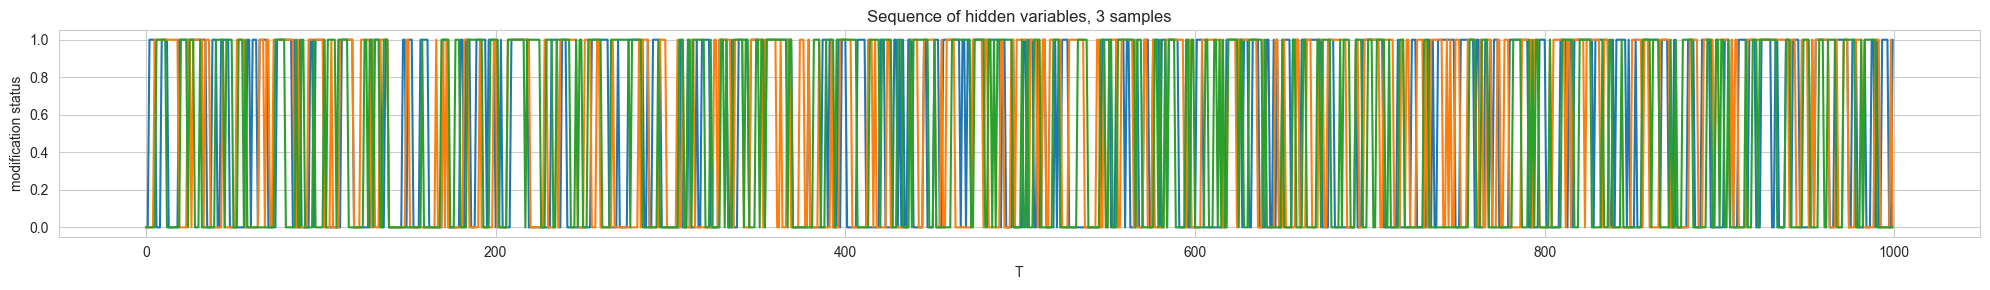

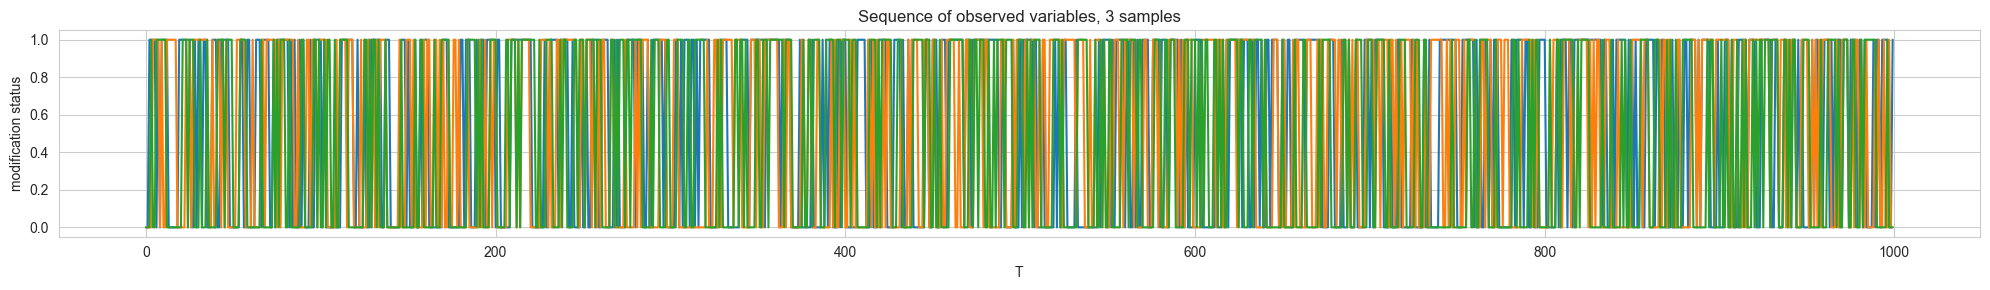

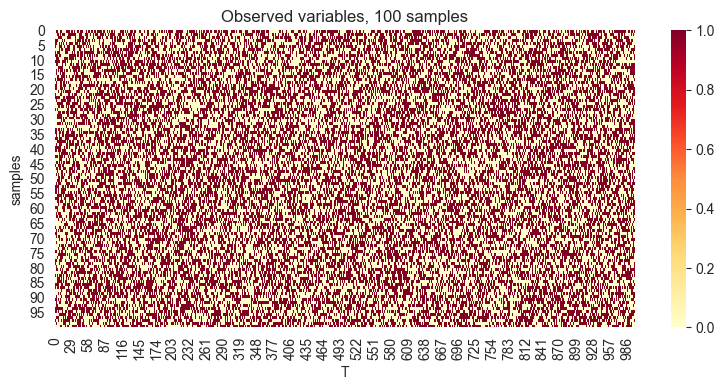

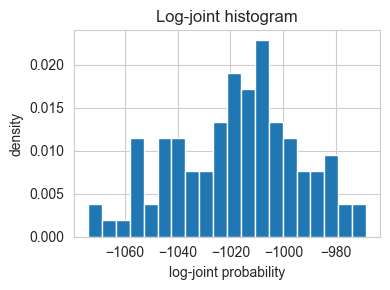

In [261]:

hmm1 = get_hmm(1)
Q2_sampling(hmm1, fig_name='Q2_hmm1')



The joint probabilities are very small because the transition matrix and the emission matrix are relatively far from the identity matrix. 
This implies that the randomness (or entropy) in the model is large, meaning that the system transitions between states frequently and the observations can vary significantly. 
As a result, each individual sequence of observations and hidden states becomes rare, leading to very small joint probabilities. 
In essence, the higher the entropy, the more unique each sample is, which decreases the probability of any specific sample occurring.



Load HMM2. CPDs:
prior
['prior(0)=1.000' 'prior(1)=0.000']
transition_mat
[['tau(0->0)=0.999' 'tau(1->0)=0.001']
 ['tau(0->1)=0.005' 'tau(1->1)=0.995']]
emission_mat
[['e(0->0)=0.990' 'e(0->1)=0.010']
 ['e(1->0)=0.010' 'e(1->1)=0.990']]




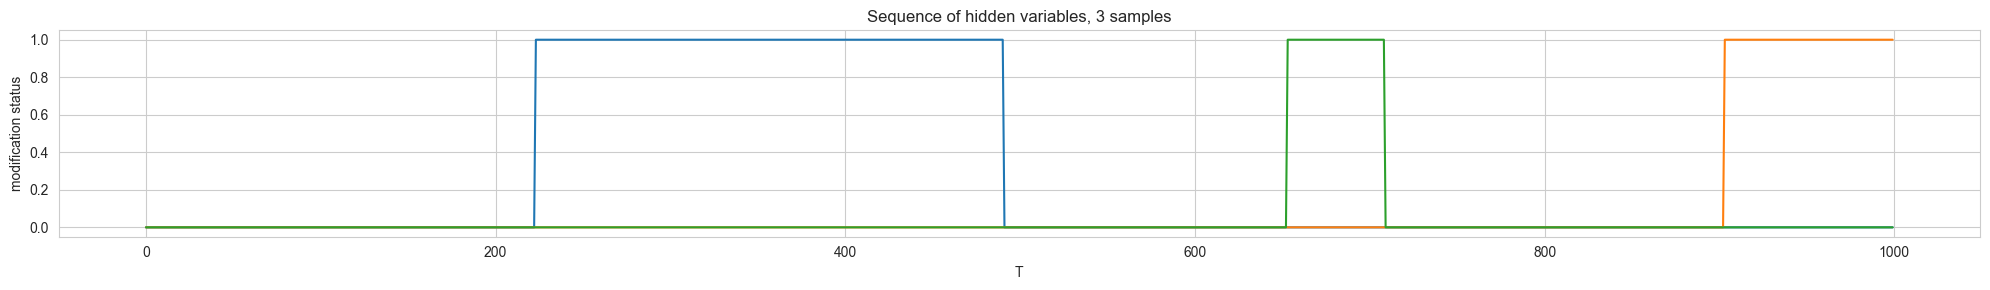

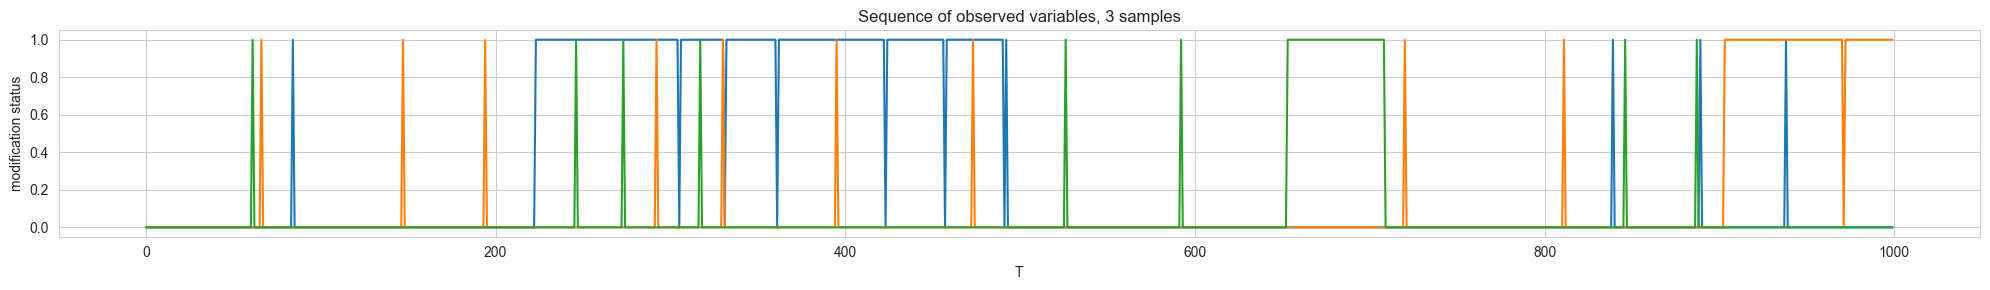

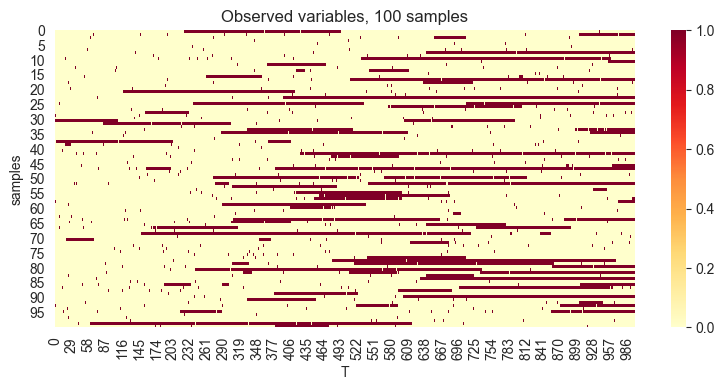

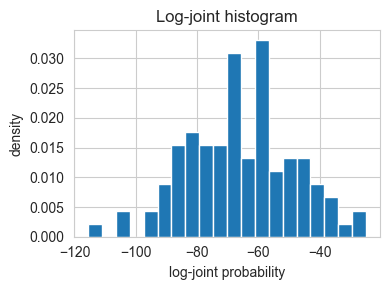

In [262]:
hmm2 = get_hmm(2)
Q2_sampling(hmm2, fig_name='Q2_hmm2')


The differences between the results of HMM1 and HMM2 are evident in the log joint probabilities and the behavior of hidden and observed sequences:

Differences:

	1.	Log Joint Probabilities:
	•	HMM1: Log joint probabilities are much smaller (more negative).
	•	HMM2: Log joint probabilities are higher (less negative).
	2.	Hidden and Observed Sequences:
	•	HMM1: Frequent transitions between states, indicating high randomness.
	•	HMM2: Fewer transitions, indicating more stability and persistence in states.

Explanation:

	1.	Transition and Emission Matrices:
	•	HMM1: The matrices are far from the identity matrix, implying high entropy (more randomness). This results in lower log joint probabilities because each sequence is rarer.
	•	HMM2: The matrices are closer to the identity matrix, implying lower entropy (less randomness). This results in higher log joint probabilities because sequences are more predictable.
	2.	Entropy and Probability Distribution:
	•	High Entropy (HMM1): Greater randomness means lower probability for specific sequences, resulting in very negative log joint probabilities.
	•	Low Entropy (HMM2): Less randomness increases the probability for specific sequences, resulting in higher log joint probabilities.

In summary, HMM1’s higher entropy leads to more random and rare sequences with lower log joint probabilities, while HMM2’s lower entropy leads to more stable and common sequences with higher log joint probabilities.

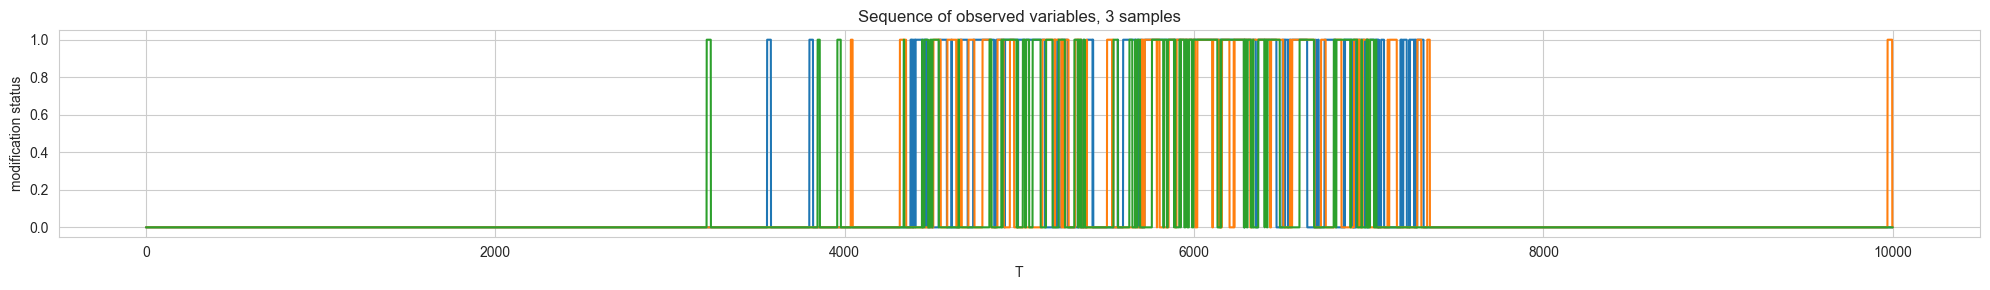

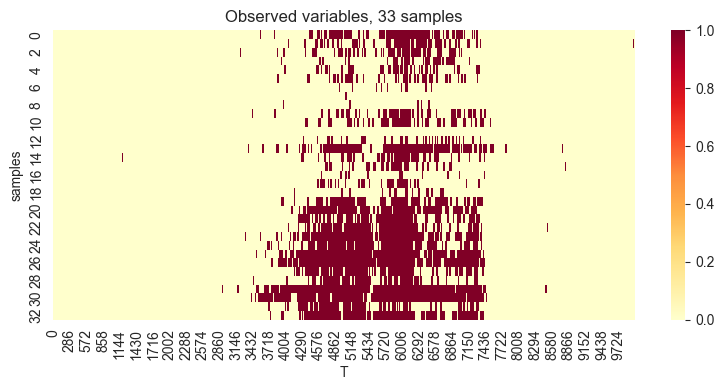

In [263]:
small_data = load_data('small_binary_data')
plot_samples(small_data, fig_name='Q2_real_data')



The real data from small_binary_data.csv shows a distinct pattern where there are many 1’s clustered in the middle of the sequence, 
while 0’s appear predominantly at the beginning and end. This indicates that the sequence does not follow the typical Markov properties assumed in HMMs.

Differences and Explanation:

	1.	Pattern Differences:
	•	Real Data: There is a clear structure with 1’s clustering in the middle and 0’s at the edges.
	•	HMM Sampled Data: The sampled data shows more randomness and frequent state transitions as expected from a Markov process.
	2.	Explanation:
	•	The real data exhibits a non-Markovian behavior where the occurrence of states (0’s and 1’s) is not solely dependent on the previous state but rather indicates a structured or periodic phenomenon.
	•	This clustering pattern suggests that the transitions between states are not memoryless, which is a fundamental assumption of HMMs.

Fit with HMM Model Assumptions:

	•	Does this data fit the HMM model assumptions?
	•	No. The real data does not fit well with HMM assumptions because HMMs assume that the probability of transitioning to the next state depends only on the current state (Markov property), and this pattern indicates dependencies that span multiple states.

In summary, the real data shows a clear deviation from the assumptions of an HMM, as evidenced by the structured clustering of states, 
which suggests that the real-world process generating this data has a different underlying mechanism than what an HMM can capture.

In [264]:
# Q3
print('''
    ########################################
    ##########         Q3         ##########
    ########################################
''')
hmm = get_hmm(2)


    ########################################
    ##########         Q3         ##########
    ########################################

Load HMM2. CPDs:
prior
['prior(0)=1.000' 'prior(1)=0.000']
transition_mat
[['tau(0->0)=0.999' 'tau(1->0)=0.001']
 ['tau(0->1)=0.005' 'tau(1->1)=0.995']]
emission_mat
[['e(0->0)=0.990' 'e(0->1)=0.010']
 ['e(1->0)=0.010' 'e(1->1)=0.990']]




For each t=1...T and k in Val(X) we define P[t,k] = P(X_t = k).

1. How can we calculate P [1, k] directly from the network CPDs?
P[1, k] = Pr(X_1 = k) and is given directly by the initial state distribution (prior distribution) of the HMM.  

2. P[t, k] = P(X_t = k) = sum_{l in Val(x)} P(X_t = k | X_{t-1}=l) * P(X_{t-1} = l) = P(X_t = k | X_{t-1}=l) * P[t-1, l]
Implement in the HMM class the method log_p_Xt, that calculates the table log P [t, k] = log p (Xt = k).






In [265]:
log_prior_Xt = hmm.log_prior_Xt()

In [266]:
log_prior_Xt

array([[ 0.00000000e+00,            -inf],
       [-1.00050033e-03, -6.90775528e+00],
       [-1.99599066e-03, -6.21761261e+00],
       ...,
       [-1.81825938e-01, -1.79424125e+00],
       [-1.81828911e-01, -1.79422634e+00],
       [-1.81831866e-01, -1.79421153e+00]])

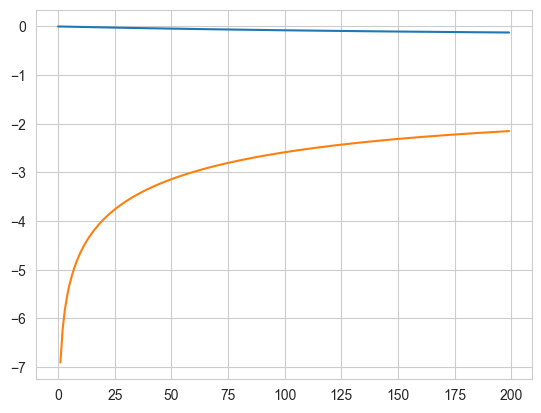

In [267]:
plt.plot(log_prior_Xt[:200])

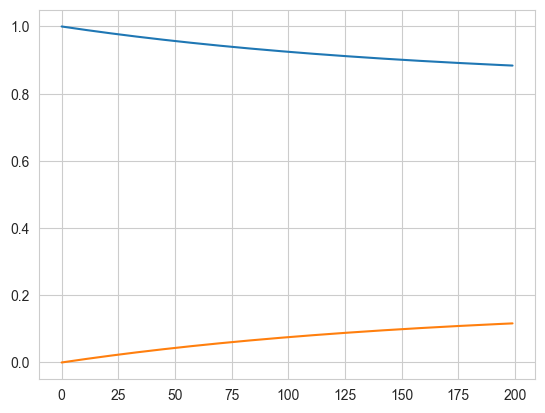

In [268]:
plt.plot(np.exp(log_prior_Xt[:200]))

3. Implement in the HMM class the method log_p_Xt_given_Ot, that calculates log p (Xt | ot).
TODO ask if we should consider the case where p = 0 (for example in hmm2, O_1 won't change for us the posterior (and the calculation will be wrong)

In [269]:
hidden, obs = hmm.sample(100)

In [270]:
log_posterior = hmm.log_naive_posterior_Xt(obs)

In [271]:
np.exp(log_posterior[0])

array([[1.00000000e+00, 0.00000000e+00],
       [9.99989889e-01, 1.01110190e-05],
       [9.99979819e-01, 2.01812491e-05],
       ...,
       [9.97989853e-01, 2.01014718e-03],
       [9.97989817e-01, 2.01018305e-03],
       [9.97989781e-01, 2.01021871e-03]])

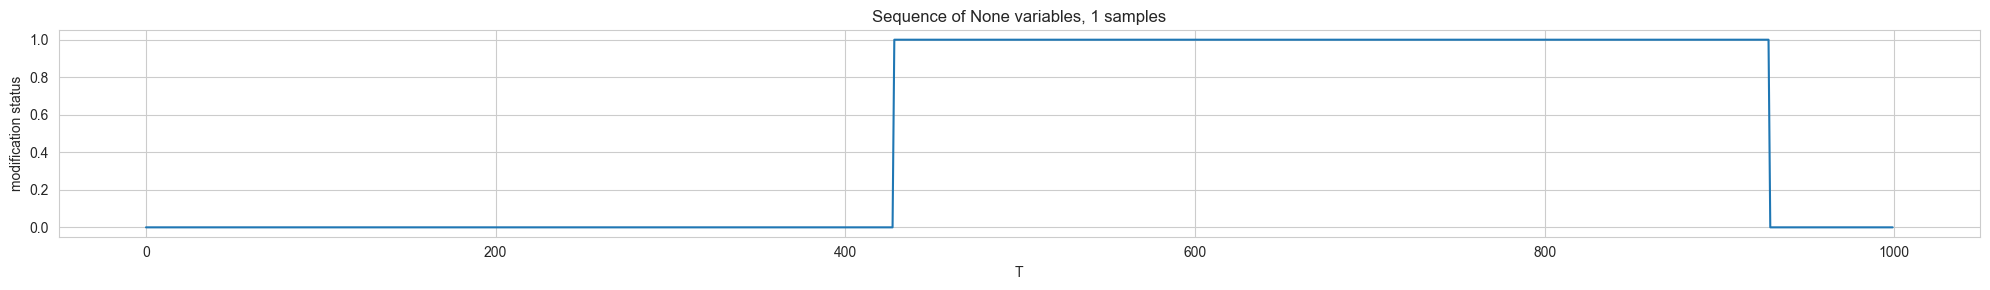

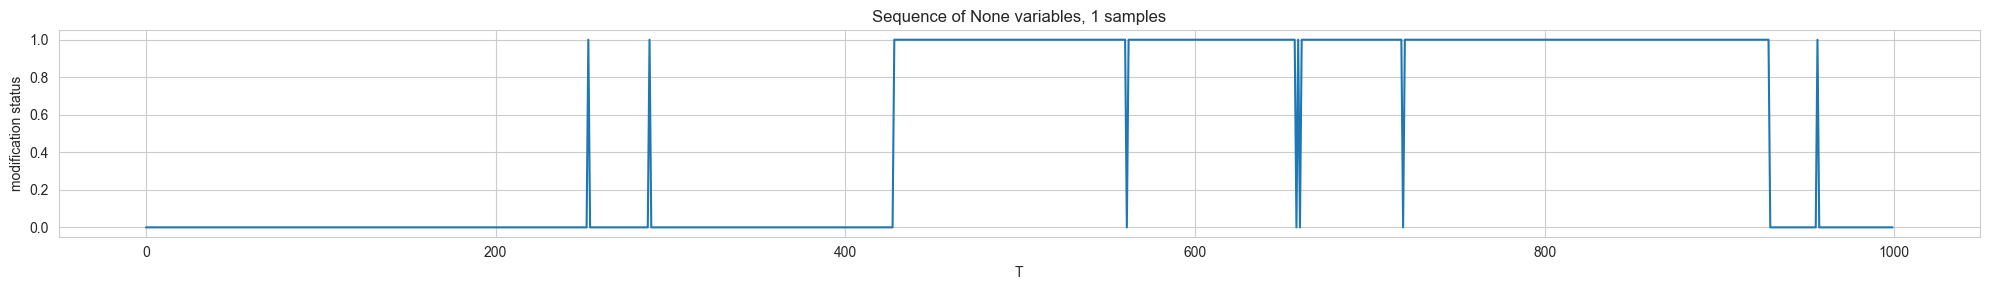

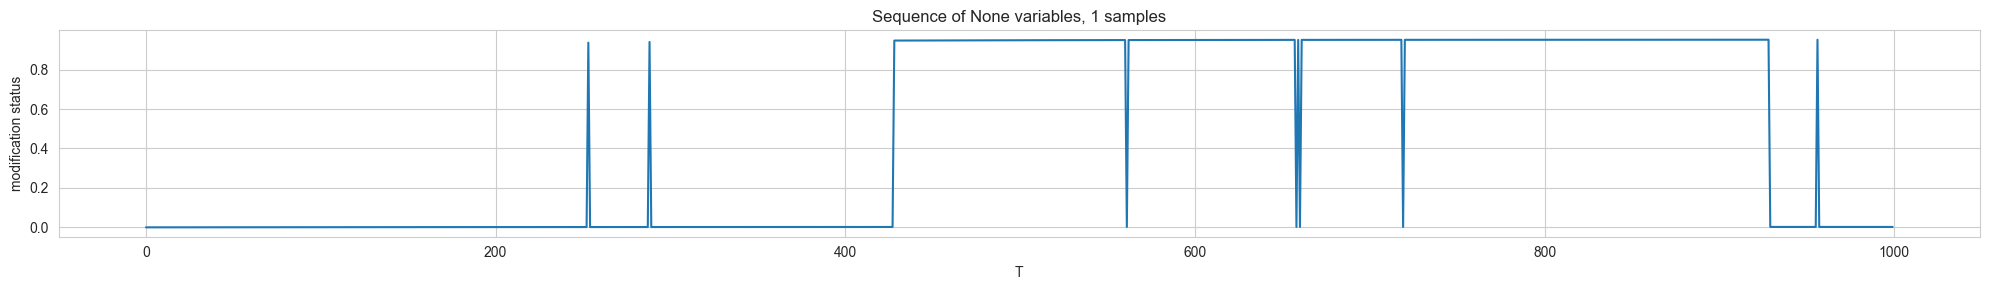

In [272]:
plot_sequence(np.matrix([ hidden[2] ]).T)
plot_sequence(np.matrix([ obs[2] ]).T)
plot_sequence(np.matrix([ np.exp(log_posterior[2,:, 1]) ]).T)


4. F[t, k] = log_p(X_t = k | O_1 = o1, ... , O_t = o_t)
Implement in the HMM class a method log_likelihood, that calculate the log-likelihood of the observations log p (o1:m).

In [273]:
log_likelihood = hmm.log_likelihood(obs)

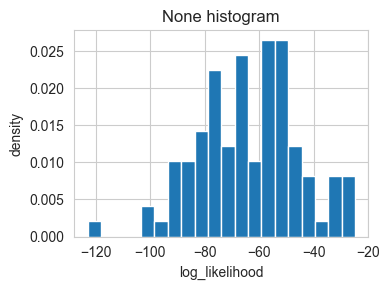

In [274]:
plot_histogram(log_likelihood, xlabel='log_likelihood')

In [281]:
# Q4
print('''
    ########################################
    ##########         Q4         ##########
    ########################################
''')
hmm2 = get_hmm(2)


    ########################################
    ##########         Q4         ##########
    ########################################

Load HMM2. CPDs:
prior
['prior(0)=1.000' 'prior(1)=0.000']
transition_mat
[['tau(0->0)=0.999' 'tau(1->0)=0.001']
 ['tau(0->1)=0.005' 'tau(1->1)=0.995']]
emission_mat
[['e(0->0)=0.990' 'e(0->1)=0.010']
 ['e(1->0)=0.010' 'e(1->1)=0.990']]




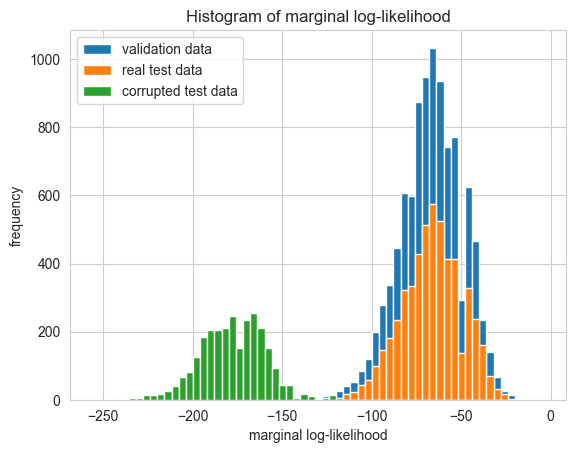

In [286]:
########################################
##########         Q4         ##########
########################################
def Q4_identify_corrupt_data(hmm):
    """
    Loads the data and plots the histograms. Rest is TODO.
    Your job is to compute the validation_marginal_log_likelihood, real_marginal_log_likelihood and
    corrupt_marginal_log_likelihood below.
    """
    # get data
    validation_data = load_data('validation_data')
    test_data = load_data('test_data')
    '''
    TODO. Calculate marginal_log_likelihood on validation data, define prediction rule, 
            and calculate marginal_log_likelihood of test samples classified as real and as corrupted.
    '''
    validation_marginal_log_likelihood = hmm.log_likelihood(validation_data)
    test_marginal_log_likelihood = hmm.log_likelihood(test_data)
    
    validation_log_likelihood_expectation = np.average(validation_marginal_log_likelihood)
    validation_log_likelihood_std = np.std(validation_marginal_log_likelihood)
    
    is_corrupted = [log_p_O < validation_log_likelihood_expectation - 3 * validation_log_likelihood_std for log_p_O in test_marginal_log_likelihood]
    
    real_marginal_log_likelihood = test_marginal_log_likelihood[ ~np.array(is_corrupted)]
    corrupt_marginal_log_likelihood = test_marginal_log_likelihood[is_corrupted]

    # plot histograms
    plt.title('Histogram of marginal log-likelihood')
    mi = np.min([corrupt_marginal_log_likelihood.min(), real_marginal_log_likelihood.min(),
                 validation_marginal_log_likelihood.min()])
    _, bins, _ = plt.hist(validation_marginal_log_likelihood, label='validation data', bins=np.arange(mi - 10, 0, 4))
    plt.hist(real_marginal_log_likelihood, label='real test data', bins=bins)
    plt.hist(corrupt_marginal_log_likelihood, label='corrupted test data', bins=bins)
    plt.xlabel('marginal log-likelihood')
    plt.ylabel('frequency')
    plt.legend()
    plt.savefig('plots/Q4_hist', bbox_inches='tight')
    plt.show()
    
    
Q4_identify_corrupt_data(hmm2)

The histogram of marginal log-likelihoods shows three distinct distributions for validation data, real test data, and corrupted test data. Here’s an explanation of the observed results:

	1.	Validation Data (Blue):
        •	The validation data shows a peak around -50 to -100 in the marginal log-likelihood.
        •	The distribution appears to be roughly normal, centered around these values.
	2.	Real Test Data (Orange):
        •	The real test data overlaps significantly with the validation data but is slightly shifted to lower log-likelihood values.
        •	This suggests that the real test data is similar to the validation data but contains some deviations, likely due to noise or slight differences.
	3.	Corrupted Test Data (Green):
        •	The corrupted test data shows a distinct peak around -150 to -200 in the marginal log-likelihood.
        •	The significantly lower log-likelihood values indicate substantial deviations from the model, suggesting anomalies or patterns not captured by the model.

Key Observations:
	•	Overlap Between Validation and Real Test Data: The overlap indicates the model captures the patterns in the real data reasonably well, with slight variations reflected in the lower log-likelihoods.
	•	Separation of Corrupted Data: The clear separation of corrupted data, with much lower log-likelihoods, demonstrates the model’s ability to identify anomalies or outliers effectively.

Conclusion:

The histogram shows that the model can distinguish between real test data, and corrupted test data based on their marginal log-likelihoods. 